In [1]:
import pandas as pd
import numpy as np

In [48]:
app = pd.read_csv('/Users/mr.tian/Desktop/application_record.csv')
credit = pd.read_csv('/Users/mr.tian/Desktop/credit_record.csv')

In [10]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [49]:
bad_rows = credit[credit['STATUS'].isin(['2', '3', '4', '5'])]

In [50]:
bad_labels = (bad_rows[['ID']].drop_duplicates().assign(bad_customer=1))

In [51]:
bad_labels.head()

,ID,bad_customer
8911,5002126,1
11778,5002255,1
12370,5002283,1
12802,5002303,1
14488,5002380,1


In [52]:
df = pd.merge(app, bad_labels, on='ID', how='left')
df['bad_customer'] = df['bad_customer'].fillna(0)

In [54]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].replace(np.nan, 'Unknown')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [56]:
for col in df.columns:
    print(df[col].name, df[col].nunique())

ID 438510
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
CNT_CHILDREN 12
AMT_INCOME_TOTAL 866
NAME_INCOME_TYPE 5
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 5
NAME_HOUSING_TYPE 6
DAYS_BIRTH 16379
DAYS_EMPLOYED 9406
FLAG_MOBIL 1
FLAG_WORK_PHONE 2
FLAG_PHONE 2
FLAG_EMAIL 2
OCCUPATION_TYPE 19
CNT_FAM_MEMBERS 13
bad_customer 2


In [57]:
df.drop(columns=['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

In [58]:
cols = [
     'CODE_GENDER', 
     'FLAG_OWN_CAR', 
     'FLAG_OWN_REALTY', 
     'NAME_INCOME_TYPE', 
     'NAME_EDUCATION_TYPE', 
     'NAME_FAMILY_STATUS', 
     'NAME_HOUSING_TYPE', 
     'OCCUPATION_TYPE'
]

df = pd.get_dummies(df, columns=cols, drop_first=True, dtype=int)

In [70]:
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].fillna(0)

In [75]:
df = df.drop(columns=['FLAG_MOBIL'])

In [81]:
X = df.drop(columns=['ID', 'bad_customer'], axis=1)
y = df['bad_customer']

In [82]:
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test  = X_test.replace([np.inf, -np.inf], 0)

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

models = {
    'Logistic': Pipeline([
        ('scaler', RobustScaler()),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear',
            C=1.0,
            random_state=42
        ))
    ]),

    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=10,
        min_samples_split=20,
        class_weight='balanced_subsample',
        random_state=42
    ),

    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )
}


for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    print(f"{name}:",
         f"accuracy={accuracy_score(y_test, pred):.4f}, ",
         f"recall={recall_score(y_test, pred):.4f},",
         f"f1_score={f1_score(y_test, pred):.4f},",
         f"roc_auc={roc_auc_score(y_test, proba):.4f}")

Logistic: accuracy=0.6182,  recall=0.4636, f1_score=0.0030, roc_auc=0.5875
RandomForest: accuracy=0.9745,  recall=0.3818, f1_score=0.0362, roc_auc=0.7332
XGBoost: accuracy=0.8738,  recall=0.5545, f1_score=0.0109, roc_auc=0.7685


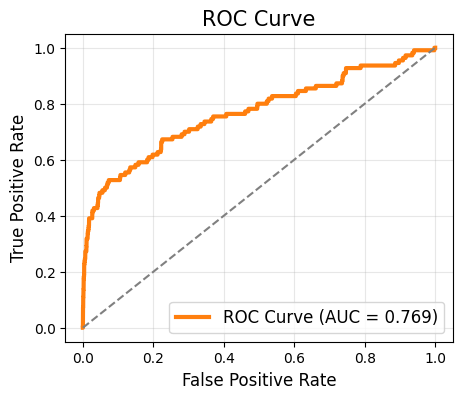

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='#FF7F0E', linewidth=3,
         label=f'ROC Curve (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()